# Selecting White Dwarfs from SDSS with ML

We are trying to repeat my past work on selecting white dwarfs from SDSS, but this time using machine learning to do so.

## Data Sources

### Kepler et al 2015

Paper is here: https://ui.adsabs.harvard.edu/abs/2015MNRAS.446.4078K/abstract

Data archive is here: https://heasarc.gsfc.nasa.gov/W3Browse/all/sdssdr10wd.html

We need ra, dec and classification basically, but can grab more. I downloaded as an excel file and then used excel to create a csv. That was the easiest way to get it into SDSS. It is stored at `data/WDCatalogKeplerEtAl2015/download.[xls|csv]`.

### SDSS

We are using CasJobs to get data: http://skyserver.sdss.org/CasJobs/MyDB.aspx

The above Kepler et al. 2015 data doesn't seem to have an SDSS ID, so it is a bit tricky to match to exact SDSS objects. We need to upload the data to a table (I called it `"WDCatalogKeplerEtAl2015"`), and then use SDSS to do a position search in the DR10 context to find the corresponding object ID:

    SELECT
       n.objid,
       m.*,
       n.distance
    INTO MyDB.WDCatalogKeplerEtAl2015wObjId
    FROM MyDB.WDCatalogKeplerEtAl2015 AS m
       CROSS APPLY dbo.fGetNearestObjEq( m.ra, m.dec, 0.5) AS n
       
This created a table called `"WDCatalogKeplerEtAl2015wObjId"`, which we downloaded as `data/WDCatalogKeplerEtAl2015/w_objid.csv`.

We also need to figure out all of the spectra that Kepler looked through, because we need a table of measurements for *both* WDs and non-WDs. So we try to emulate the query they used to select their data:

> required to have colours within the ranges g < 19.2, (u− r) <
> 0.4, −1 < (u − g) < 0.3, −1 < (g − r) < 0.5, and to have
> low Galactic extinction Ar < 0.5 mag.

    SELECT
      objid, ra, dec, psfMag_u, psfMag_g, psfMag_r, psfMag_i, psfMag_z, extinction_r, class, subClass
    INTO MyDB.SpecPhotoAllDR10KeplerEtAl2015
    FROM SpecPhotoAll
    WHERE
      psfMag_g <= 19.2
      and (psfMag_u - psfMag_r) < 0.4
      and (psfMag_u - psfMag_g) > -1
      and (psfMag_u - psfMag_g) < 0.3
      and (psfMag_g - psfMag_r) > -1
      and (psfMag_g - psfMag_r) < 0.5
      and extinction_r < 0.5
      and flags & 0x10000000 != 0
      and flags & 0x8100000c00ac = 0
      
Which we ran on the DR10 context to get a table `"SpecPhotoAllDR10KeplerEtAl2015"`. We downloaded this as `data/SpecPhotoAllKeplerEtAl2015/dr10.csv`.

We also ran the above query on the DR16 context to get a table `"SpecPhotoAllDR16KeplerEtAl2015"`. We downloaded this as `data/SpecPhotoAllKeplerEtAl2015/dr16.csv`.

## Data Cleaning

### Creating Training Data

We need a dataset with labels of WD vs non-WD, and potentially useful identification columns, e.g: colours & extinction. We should therefore iterate through the `"SpecPhotoAllDR10KeplerEtAl2015"` data and add a column of WD vs non-WD from the `"WDCatalogKeplerEtAl2015wObjId"` data.

In [1]:
import pandas as pd

/Users/jgirven/learning/astronomy/env/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
spec_photo_all = pd.read_csv('../data/SpecPhotoAllKeplerEtAl2015/dr10.csv')
spec_photo_all = spec_photo_all.groupby('objid').first().reset_index()
spec_photo_all.head()

,objid,ra,dec,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,extinction_r,class,subClass
0,1237645943978393681,55.255792,0.898048,17.43467,17.84416,18.24815,18.55756,18.87360,0.260842,STAR,O
1,1237646587710865767,82.578884,0.674296,18.94333,18.97837,19.33775,19.57653,19.89920,0.373240,STAR,WD
2,1237648672921944252,244.813960,-0.937776,18.84514,19.10553,19.44680,19.73213,20.01712,0.289759,STAR,OB
3,1237648673458421817,243.884390,-0.458439,17.16446,17.12208,16.91375,16.46347,16.49001,0.358432,QSO,BROADLINE
4,1237648673458487559,244.112960,-0.492504,17.35627,17.69995,18.11275,18.37699,18.65071,0.349579,STAR,O


In [3]:
wd_catalog = pd.read_csv('../data/WDCatalogKeplerEtAl2015/w_objid.csv')
wd_catalog.head()

,objid,name,ra,dec,gmag,gmag_error,spect_type,t_eff,t_eff_error,log_g,distance
0,1237668731457241431,SDSS J200959.27-115519.92,302.49690,-11.92220,18.49,0.01,DO/He-sdO,47489,10000,6.500,0.000322
1,1237668731457110215,SDSS J200836.41-114629.24,302.15170,-11.77479,16.56,0.00,He-sdO,47587,200,6.688,0.000232
2,1237668758310879994,SDSS J200815.48-110103.99,302.06450,-11.01778,16.88,0.00,He-sdO,50000,200,6.500,0.000462
3,1237652947990806617,SDSS J001844.35-093855.14,4.68479,-9.64865,18.63,0.02,sdB,20530,435,5.000,0.000916
4,1237671990272720977,SDSS J135639.76-092020.90,209.16570,-9.33914,17.39,0.02,DA,8578,17,8.087,0.000780


In [4]:
cleaned_data = pd.DataFrame()

cleaned_data['is_wd'] = spec_photo_all['objid'].isin(wd_catalog['objid'])

cleaned_data['g'] = spec_photo_all['psfMag_g']
cleaned_data['u-g'] = spec_photo_all['psfMag_u'] - spec_photo_all['psfMag_g']
cleaned_data['g-r'] = spec_photo_all['psfMag_g'] - spec_photo_all['psfMag_r']
cleaned_data['r-i'] = spec_photo_all['psfMag_r'] - spec_photo_all['psfMag_i']
cleaned_data['i-z'] = spec_photo_all['psfMag_i'] - spec_photo_all['psfMag_z']
cleaned_data['extinction_r'] = spec_photo_all['extinction_r']

cleaned_data.head()

,is_wd,g,u-g,g-r,r-i,i-z,extinction_r
0,False,17.84416,-0.40949,-0.40399,-0.30941,-0.31604,0.260842
1,False,18.97837,-0.03504,-0.35938,-0.23878,-0.32267,0.373240
2,False,19.10553,-0.26039,-0.34127,-0.28533,-0.28499,0.289759
3,False,17.12208,0.04238,0.20833,0.45028,-0.02654,0.358432
4,False,17.69995,-0.34368,-0.41280,-0.26424,-0.27372,0.349579


## Plot cleaned data

2142 WDs from 29524 total


Text(0, 0.5, 'r-i')

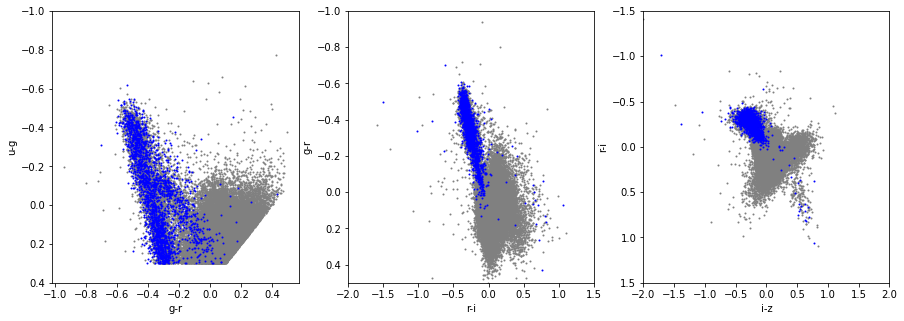

In [5]:
import pylab as pl

print(f"{sum(cleaned_data['is_wd'] == True)} WDs from {len(cleaned_data)} total")

is_wd = cleaned_data['is_wd'] == True
not_wd = cleaned_data['is_wd'] == False

pl.figure(figsize=(15, 5))

pl.subplot(131)
pl.scatter(cleaned_data[not_wd]['g-r'], cleaned_data[not_wd]['u-g'], c='grey', s=1)
pl.scatter(cleaned_data[is_wd]['g-r'], cleaned_data[is_wd]['u-g'], c='b', s=1)
pl.ylim(0.4, -1)
pl.xlabel('g-r')
pl.ylabel('u-g')

pl.subplot(132)
pl.scatter(cleaned_data[not_wd]['r-i'], cleaned_data[not_wd]['g-r'], c='grey', s=1)
pl.scatter(cleaned_data[is_wd]['r-i'], cleaned_data[is_wd]['g-r'], c='b', s=1)
pl.xlim(-2, 1.5)
pl.ylim(0.5, -1)
pl.xlabel('r-i')
pl.ylabel('g-r')

pl.subplot(133)
pl.scatter(cleaned_data[not_wd]['i-z'], cleaned_data[not_wd]['r-i'], c='grey', s=1)
pl.scatter(cleaned_data[is_wd]['i-z'], cleaned_data[is_wd]['r-i'], c='b', s=1)
pl.xlim(-2, 2)
pl.ylim(1.5, -1.5)
pl.xlabel('i-z')
pl.ylabel('r-i')

## Write out cleaned data

In [6]:
cleaned_data.to_csv('../data/SpecPhotoAllKeplerEtAl2015/dr10_cleaned.csv', index=False)